In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import os, random, time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import glob
import cv2
import math

import albumentations
import imgaug.augmenters as iaa
from albumentations.augmentations import functional as Fa
from albumentations.core.transforms_interface import ImageOnlyTransform
from PIL import Image, ImageOps, ImageEnhance


import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

from torch.utils.data import DataLoader,Dataset
from torchvision import transforms

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


AUTO = tf.data.experimental.AUTOTUNE


CONFIG = {
'random_seed' : 42,
'validation_split' : 0.2, # divisible 
'IMAGE_SIZE' : 224,
'batch_size' : 128,
'epoch' : 20,
'MEAN' : [0.48664735 ,0.45366779 ,0.41572613],
'STD' :  [0.26272767 ,0.25603925, 0.25867402]
}

# Seed everything for reproductiveness

random.seed(CONFIG['random_seed'])
os.environ["PYTHONHASHSEED"] = str(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

TRAIN_DIR = '../input/dogs-vs-cats/train/train/'
TEST_DIR = '../input/dogs-vs-cats/test/test/'

## Loading Cats and Dogs paths to two lists

In [2]:
CATS = glob.glob(f'{TRAIN_DIR}/cat*')
DOGS = glob.glob(f'{TRAIN_DIR}/dog*')

fig = go.Figure(data=[go.Pie(labels=['Cats','Dogs'], values=[len(CATS),len(DOGS)])])
fig.show()

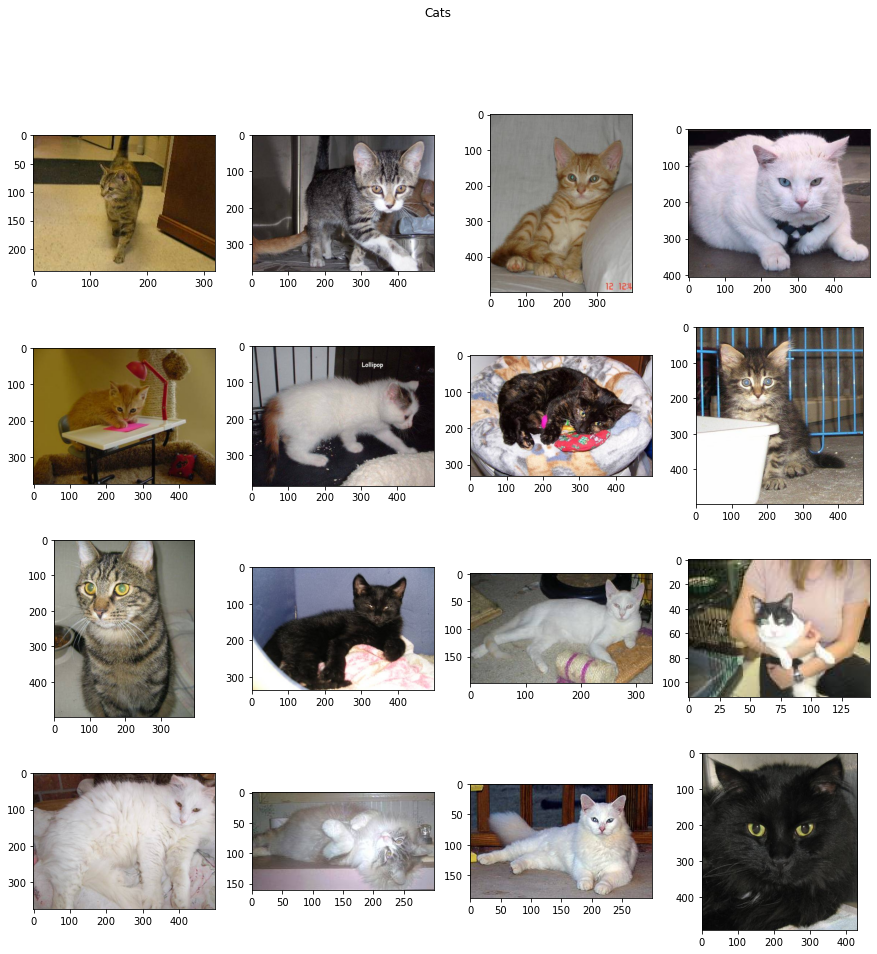

In [3]:
fig, axs = plt.subplots(4,4,figsize=(15,15))
fig.suptitle('Cats')
for index,i in enumerate(axs.flatten()):
    i.imshow(cv2.cvtColor(cv2.imread(CATS[index]),cv2.COLOR_BGR2RGB))

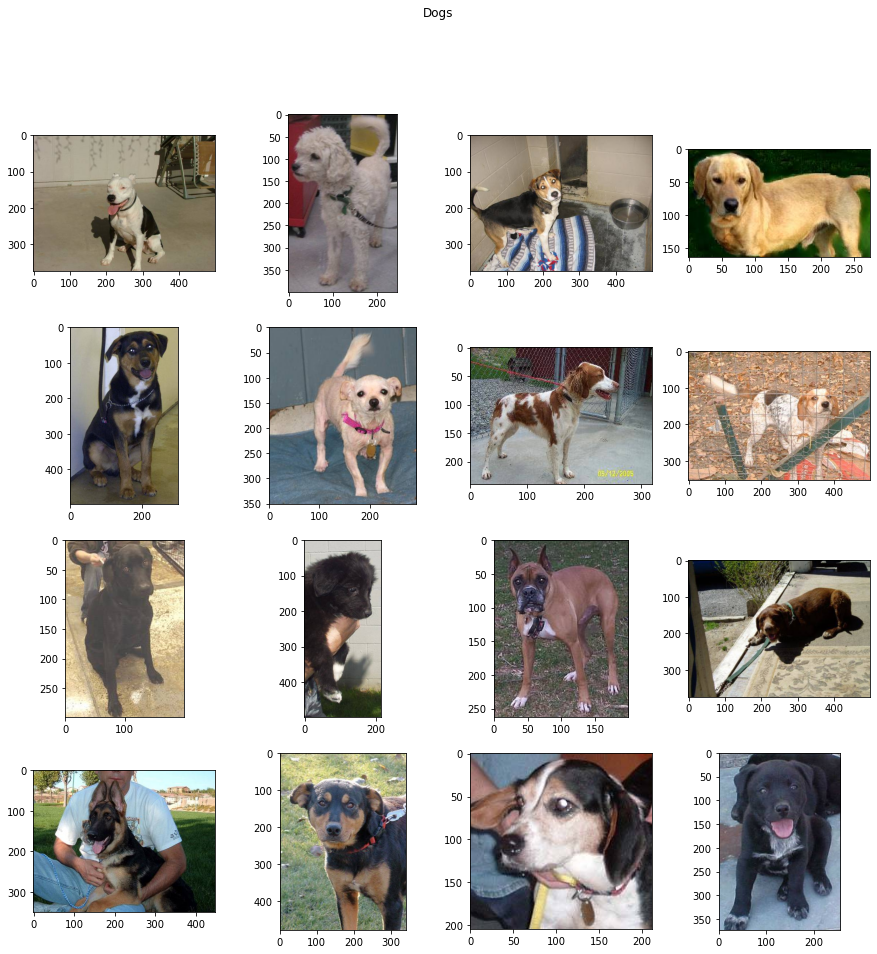

In [4]:
fig, axs = plt.subplots(4,4,figsize=(15,15))
fig.suptitle('Dogs')
for index,i in enumerate(axs.flatten()):
    i.imshow(cv2.cvtColor(cv2.imread(DOGS[index]),cv2.COLOR_BGR2RGB))

## Creating tf Datasets for train and validation

In [5]:
CATS = pd.DataFrame({'path':CATS,'label':0})
DOGS = pd.DataFrame({'path':DOGS,'label':1})

train_df = pd.concat([CATS,DOGS])
X_train,X_test,y_train,y_test = train_test_split(train_df.path.values,train_df.label.values,test_size=CONFIG['validation_split'],stratify=train_df.label,random_state=CONFIG['random_seed'])
train_df



print(len(X_train),len(X_test))

train = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test = tf.data.Dataset.from_tensor_slices((X_test,y_test))

20000 5000


# Let's use basic augmentation and see how it performs

In [6]:
def load_img_and_resize(path,label=None):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [CONFIG['IMAGE_SIZE'], CONFIG['IMAGE_SIZE']])
    if label is not None:
        return img, label
    else:
        return img

def normalize(img,label=None):
    img = tf.image.per_image_standardization(img)
    if label is not None:
        return img, label
    else:
        return img


def augment(img,label):
    img = tf.image.random_flip_left_right(img)
    return img,label

train = train.map(load_img_and_resize,num_parallel_calls=AUTO)
train = train.map(normalize,num_parallel_calls=AUTO)
train = train.map(augment,num_parallel_calls=AUTO)
train = train.batch(CONFIG['batch_size'])
train = train.prefetch(10)
train = train.repeat()

options = tf.data.Options()
options.experimental_deterministic = False
train = train.with_options(options)

test = test.map(load_img_and_resize,num_parallel_calls=AUTO).map(normalize,num_parallel_calls=AUTO).batch(CONFIG['batch_size']).prefetch(10).repeat()

In [7]:
# def calc_mean_and_std():
#     pixel_num = 0
#     temp = np.zeros((len(train_df),3))
    
#     for index,i in tqdm(enumerate(train_df.path.values)):
#         img = cv2.imread(i)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = img/255.0
#         pixel_num += img.size/3
#         temp[index] = np.sum(img,(0,1))
    
#     MEAN = np.sum(temp,0)/pixel_num
    
    
#     temp = np.zeros((len(train_df),3))
    
#     for index,i in tqdm(enumerate(train_df.path.values)):
#         img = cv2.imread(i)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = img/255.0
#         img = np.square(img - MEAN)
#     #     print(np.sum(img,(0,1)))
#     #     break
#         temp[index] = np.sum(img,(0,1))
    
#     temp = np.sum(temp,0)/pixel_num
#     STD = np.sqrt(temp)
            
    
#     return MEAN,STD

# MEAN,STD = calc_mean_and_std()

In [8]:
def make_model():

    model = keras.models.Sequential([
        keras.layers.Input(shape=(224, 224,3)),
        tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        pooling='avg'
    ),
        keras.layers.Dense(1,activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tfa.optimizers.Lookahead(tf.keras.optimizers.Adam()),
        loss='binary_crossentropy',
        metrics=['accuracy',tf.keras.metrics.AUC(),tf.keras.metrics.BinaryCrossentropy()]
    )
    model.layers[0].trainable=False
    print(model.summary())
    return model

In [9]:
def step_decay(epoch):
    initial_lrate = 0.001
    
    if epoch < 5:
        return initial_lrate
    
    drop = 0.05
    epochs_drop = float(CONFIG['epoch'])
    lrate = initial_lrate * math.pow(drop,epoch/epochs_drop)
    return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5
)

mchp = tf.keras.callbacks.ModelCheckpoint(
    'best_model', monitor='val_loss', verbose=0, save_best_only=True
)


model = make_model()
hist = model.fit(train,epochs=20,validation_data = test,steps_per_epoch=len(X_train)//CONFIG['batch_size'],validation_steps=len(X_test)//CONFIG['batch_size'],callbacks=[lrate,es,mchp])

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________
None
Epoch 1/20
156/156 [==============================] - 144s 921ms/step - loss: 0.1065 - accuracy: 0.9611 - auc: 0.9933 - binary_crossentropy: 0.1065 - val_loss: 3.0766 - val_accuracy: 0.5064 - val_auc: 0.4684 - val_binary_crossentropy: 3.0766 - lr: 0.0010
Epoch 2/20
156/156 [==============================] - 139s 893ms/step - loss: 0.0520 - accuracy: 0.9798 - auc: 0.9980 - binary_crossentropy: 0.0520 - val_loss: 0.6567 - val_accu

In [10]:
hist_df = pd.DataFrame(hist.history)
hist_df.to_csv('hist_df')

In [11]:
hist_df['epoch'] = np.arange(1,len(hist_df)+1)
hist_df

loss  accuracy       auc  binary_crossentropy  val_loss  val_accuracy  \
0   0.106517  0.961138  0.993265             0.106517  3.076591      0.506410   
1   0.052047  0.979771  0.998007             0.052047  0.656732      0.559495   
2   0.034450  0.987369  0.998959             0.034450  0.368876      0.810897   
3   0.033590  0.987923  0.999043             0.033590  0.151720      0.933894   
4   0.028954  0.989885  0.999268             0.028954  0.072908      0.970152   
5   0.009647  0.996880  0.999849             0.009647  0.040839      0.984575   
6   0.003142  0.999145  0.999994             0.003142  0.040397      0.987179   
7   0.002692  0.999245  0.999996             0.002692  0.046090      0.986378   
8   0.000831  0.999748  1.000000             0.000831  0.047744      0.986178   
9   0.000508  0.999799  1.000000             0.000508  0.043247      0.989183   
10  0.000559  0.999748  1.000000             0.000559  0.044049      0.988381   
11  0.000644  0.999799  1.000000             0.000644  0.044546      0.987780   

     val_auc  val_binary_crossentropy        lr  epoch  
0   0.468377                 3.076591  0.001000      1  
1   0.685694                 0.656732  0.001000      2  
2   0.967557                 0.368876  0.001000      3  
3   0.991987                 0.151720  0.001000      4  
4   0.996431                 0.072908  0.001000      5  
5   0.998319                 0.040839  0.000473      6  
6   0.998049                 0.040397  0.000407      7  
7   0.997703                 0.046090  0.000350      8  
8   0.997802                 0.047744  0.000302      9  
9   0.997649                 0.043247  0.000260     10  
10  0.997625                 0.044049  0.000224     11  
11  0.997227                 0.044546  0.000193     12

In [12]:
fig = px.line(hist_df,x='epoch',y=['accuracy','val_accuracy'],title='Accuracy')
fig.show()

In [13]:
fig = px.line(hist_df,x='epoch',y=['loss','val_loss'],title='Loss')
fig.show()

In [14]:
fig = px.line(hist_df,x='epoch',y=['auc','val_auc'],title='AUC')
fig.show()

In [15]:
fig = px.line(hist_df,x='epoch',y=['lr'],title='Learning rate')
fig.show()

In [16]:
def only_paths(x,y):
    return x

preds = model.predict(test.map(only_paths),steps=len(X_test)//CONFIG['batch_size'])

In [17]:
tn, fp, fn, tp = confusion_matrix(y_test[:CONFIG['batch_size']*(len(X_test)//CONFIG['batch_size'])],np.round(preds).astype(np.int32).reshape(len(preds))).ravel()
print(tn, fp, fn, tp)

2463 33 28 2468


# Plot top losses

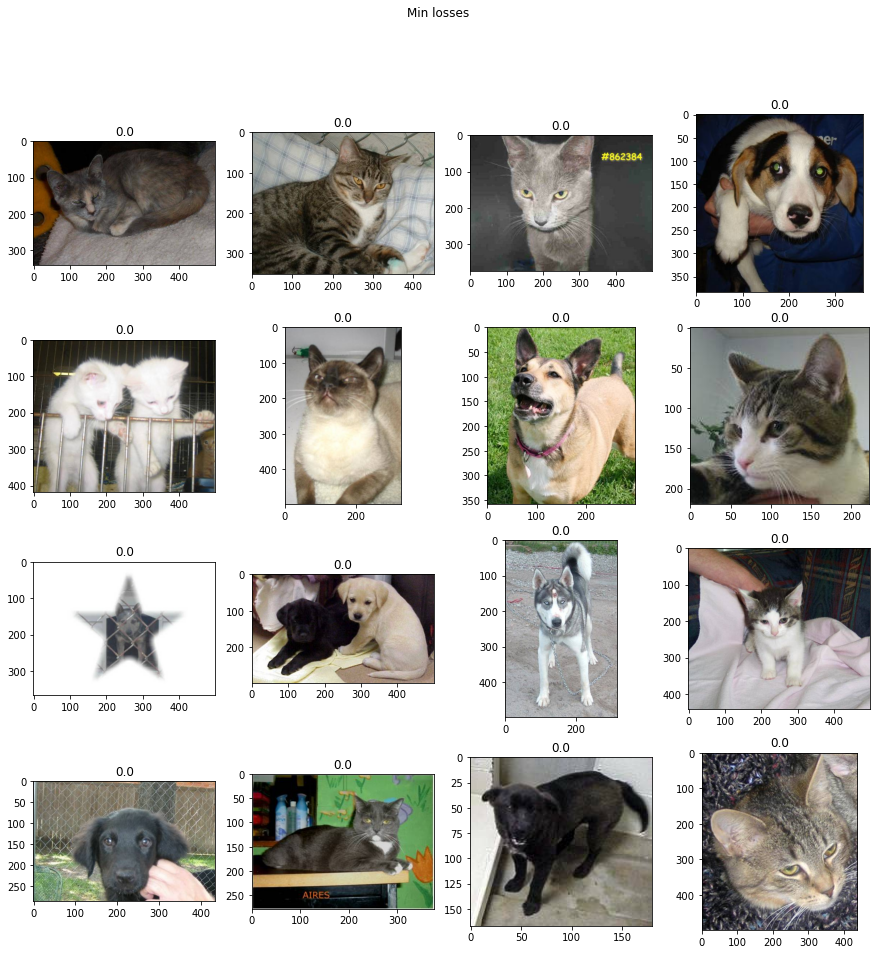

In [18]:
eval_loss = abs(preds.reshape(len(preds))-y_test[:CONFIG['batch_size']*(len(X_test)//CONFIG['batch_size'])])
arg_sorted_eval_loss = np.argsort(eval_loss)
fig, axs = plt.subplots(4,4,figsize=(15,15))
fig.suptitle('Min losses')
for index,i in enumerate(axs.flatten()):
    i.imshow(cv2.cvtColor(cv2.imread(X_train[arg_sorted_eval_loss[index]]),cv2.COLOR_BGR2RGB))
    i.set_title(str(eval_loss[arg_sorted_eval_loss[index]]))

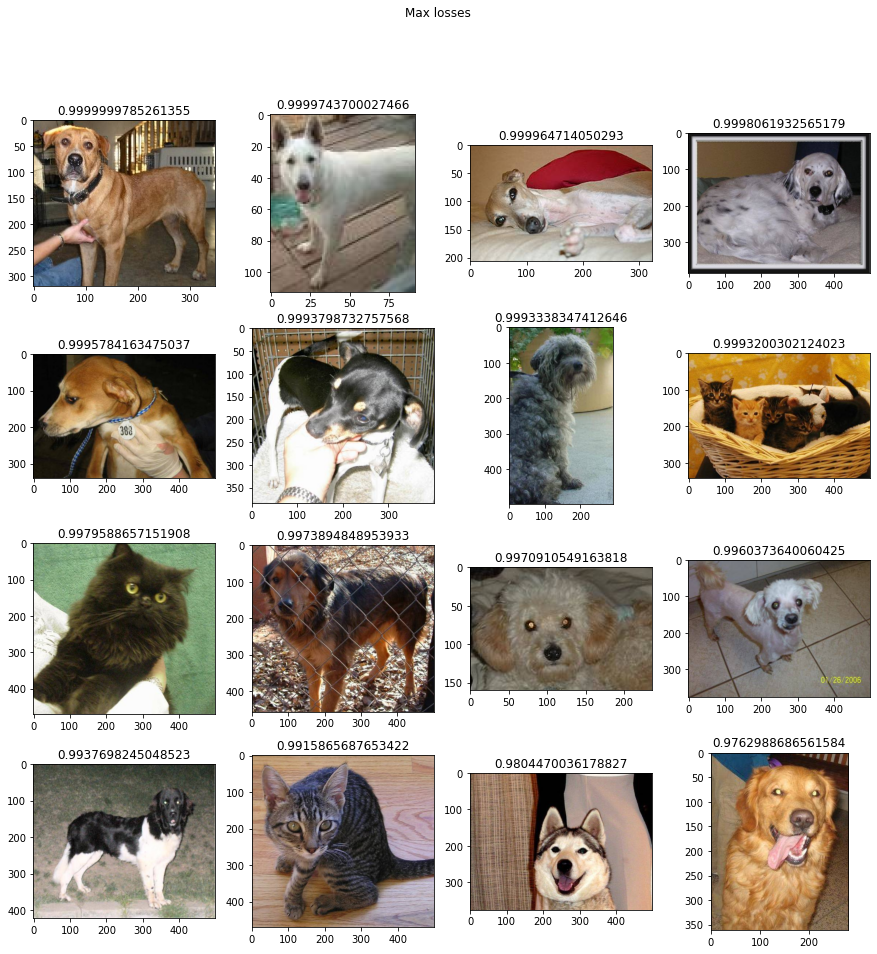

In [19]:
arg_sorted_eval_loss = np.flip(arg_sorted_eval_loss)
fig, axs = plt.subplots(4,4,figsize=(15,15))
fig.suptitle('Max losses')
for index,i in enumerate(axs.flatten()):
    i.imshow(cv2.cvtColor(cv2.imread(X_train[arg_sorted_eval_loss[index]]),cv2.COLOR_BGR2RGB))
    i.set_title(str(eval_loss[arg_sorted_eval_loss[index]]))